In [1]:
from pathlib import Path
import torchtext
torchtext.disable_torchtext_deprecation_warning()

import torch
from pathlib import Path
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

# Classsification Metrics
## 1 Confusion Matrix
To showcase a confusion matrix, let's load the Fashion MNIST data.

And we make a post-processing function that makes the label a 1 if the number is a four, and 0 otherwise.

First, we create a Dataloader

In [2]:
from mads_datasets import DatasetFactoryProvider, DatasetType
fashionfactory = DatasetFactoryProvider.create_factory(DatasetType.FASHION)
datasets = fashionfactory.create_dataset()
train = datasets["train"]
valid = datasets["valid"]

2025-02-21 14:31:03.237 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/sarmad/.cache/mads_datasets/fashionmnist
2025-02-21 14:31:03.238 | INFO     | mads_datasets.base:download_data:124 - File already exists at /home/sarmad/.cache/mads_datasets/fashionmnist/fashionmnist.pt


Now our $y$ consists of zeros and ones

In [3]:
X, y = train[0]
X.shape, y.shape, y

(torch.Size([1, 28, 28]), torch.Size([]), tensor(9, dtype=torch.uint8))

We load our basic model.

The number of outputs should be 2, because we have two classes.
Let's run this with only 100 training-steps; that way we can see the progress better.

In [4]:
logdir = Path("modellogs/dummy")

In [5]:
from mltrainer import TrainerSettings, ReportTypes, metrics
accuracy = metrics.Accuracy()

settings = TrainerSettings(
    epochs=3,
    metrics=[accuracy],
    logdir=logdir,
    train_steps=100,
    valid_steps=50,
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.GIN,],
    scheduler_kwargs={"factor": 0.5, "patience": 5},
)
settings

2025-02-21 14:31:04.341 | INFO     | mltrainer.settings:check_path:61 - Created logdir /home/sarmad/Documents/code/upperkaam/notebooks_review/Deliverable_Part_3/notebooks/5_attention/modellogs/dummy


epochs: 3
metrics: [Accuracy]
logdir: modellogs/dummy
train_steps: 100
valid_steps: 50
reporttypes: [<ReportTypes.TENSORBOARD: 2>, <ReportTypes.GIN: 1>]
optimizer_kwargs: {'lr': 0.001, 'weight_decay': 1e-05}
scheduler_kwargs: {'factor': 0.5, 'patience': 5}
earlystop_kwargs: {'save': False, 'verbose': True, 'patience': 10}

In [6]:
from typing import List, Tuple
class DummyPreprocessor:
    def __call__(self, batch: List[Tuple]) -> Tuple[torch.Tensor, torch.Tensor]:
        batchsize = len(batch)
        # we allocate some memory. This speeds up filling the batch
        X = torch.zeros(size=(batchsize, 1, 28, 28))
        Y = []
        i = 0
        for x, y in batch:
            X[i] = x
            # the label will be True if 4, False otherwise
            Y.append(int(y == 4))
            i += 1
        return X, torch.tensor(Y, dtype=torch.long)

In [7]:
streamers = fashionfactory.create_datastreamer(batchsize=32, preprocessor=DummyPreprocessor())
trainstreamer = streamers["train"]
validstreamer = streamers["valid"]

2025-02-21 14:31:04.353 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/sarmad/.cache/mads_datasets/fashionmnist
2025-02-21 14:31:04.354 | INFO     | mads_datasets.base:download_data:124 - File already exists at /home/sarmad/.cache/mads_datasets/fashionmnist/fashionmnist.pt


In [8]:
from mltrainer import imagemodels, Trainer

model = imagemodels.CNN(2, (3,3), 32, 64)

trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    traindataloader=trainstreamer.stream(),
    validdataloader=validstreamer.stream(),
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
)
trainer.loop()

2025-02-21 14:31:04.389 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to modellogs/dummy/20250221-143104
2025-02-21 14:31:04.390 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 100/100 [00:01<00:00, 86.32it/s]
2025-02-21 14:31:05.824 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.3416 test 0.2814 metric ['0.9025']
100%|██████████| 100/100 [00:01<00:00, 99.61it/s]
2025-02-21 14:31:07.099 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2523 test 0.2476 metric ['0.8938']
100%|██████████| 100/100 [00:01<00:00, 98.36it/s]
2025-02-21 14:31:08.389 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2198 test 0.1754 metric ['0.9337']
100%|██████████| 3/3 [00:03<00:00,  1.33s/it]


Naively, this looks very good. The first epoch is alreay at 90%. But not so fast... 
What would you expect from blind guessing? Exactly 90% accuracy if you would guess all 0! Because 90% is a 0!
That gives us a different perspective on the 90 or 94% you might get... So we need something more complex than just accuracy.

<font color='green'>

**Answer:** the accuracy is not the best measure for the perfromance of the model if the model has different number of sample for each class. Hence, 90% accruacy maybe misleading as it is only able get the one class right by just blind guessing. So, we need some other metric to rate the model's performance. 

</font>

In [9]:
from tqdm import tqdm
y_true = []
y_pred = []

validdata = validstreamer.stream()
for _ in tqdm(range(len(validstreamer))):
    X, y = next(validdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1)  # we get the one with the highest probability
    y_pred.append(yhat.tolist())
    y_true.append(y.tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

100%|██████████| 312/312 [00:01<00:00, 187.87it/s]


Let's collect all predictions in a list, and flatten the list with a list comprehension.

With this, we can use the confusion matrix from sklearn and plot it with seaborn.

[Text(0.5, 80.7222222222222, 'Predicted'),
 Text(95.72222222222221, 0.5, 'Target')]

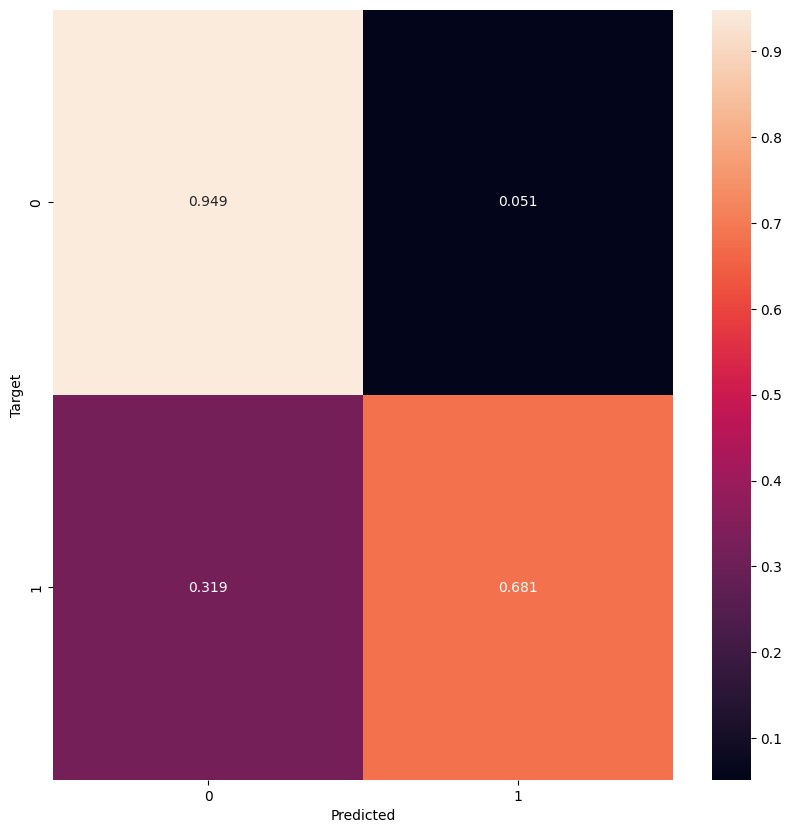

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve, roc_curve

cfm = confusion_matrix(y, yhat)
cfm_norm = cfm / np.sum(cfm, axis=1, keepdims=True)
plot = sns.heatmap(cfm_norm, annot=cfm_norm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

You can see that the target 0 is predicted as a 0 for 94% of the time. So that is going well.
However, the target 1 (number is a four) is predicted as actually 1 is much worse! 

## 2 Precision, Recall and F1
The F1-score is a useful metric for problems with unblanaced datasets; it returns a number between 0 and 1 that gives an indication of how well a model is doing in the classification task. Other useful metrics are *precision* and *recall*.

**Precision**: how many of the samples *predicted* as positive are actually positive

$$ Precision = \frac{TP}{TP + FP}$$

**Recall**: how many of *actual* positive samples are indeed predicted as positive

$$ Recall = \frac{TP}{TP + FN}$$

**F-score**: the harmonic mean of precision and recall

$$ F = 2 * \frac{precision * recall}{precision + recall} $$

The F1-score of the dummy classifier is zero! 
Lets first visualize the f1-metric:

/tmp/ipykernel_92591/3096192362.py:6: RuntimeWarning: invalid value encountered in scalar divide
  return 2 * (prec*rec)/(prec+rec)


<Axes: >

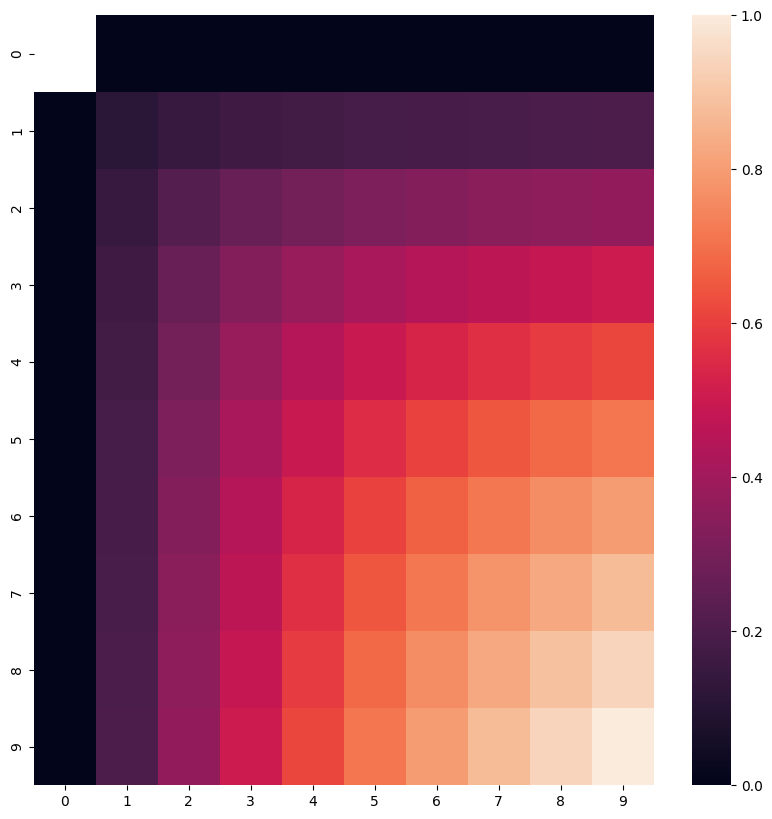

In [11]:
k = 10
prec = np.linspace(0, 1, k) # k precision values
rec = np.linspace(0, 1, k) # k recall values

def f1(prec, rec): # the f1 metric
    return 2 * (prec*rec)/(prec+rec)

from itertools import product
combinations = [f1(p,r) for p in prec for r in rec] # a list of combinations
grid = np.reshape(combinations, (k,k)) # reshaped into a grid
sns.heatmap(grid) # and heatmapped

This makes sense: if one of precision or recall is low, the outcome is low. If both are high, the outcome is high. This is a balanced mixture of both.

In [12]:
f1_score(y, yhat)

0.6358543417366946

As you can see, the f1 score is much more realistic than the accuracy.

Another approach is to look at precision-recall:

- recall describes how many correct items you actually retrieved, of all items you could have retrieved
- precision describes of the items you labeled, you actually labeled them correct.

For this, we are not going to look at the argmax, but directly at the logits of one of the classes.

In [13]:
y_true = []
y_pred = []


for _ in tqdm(range(len(validstreamer))):
    X, y = next(validdata)
    yhat = model(X)
    yhat = yhat[:, 1] # we get the probability of being a 4
    y_pred.append(yhat.tolist())
    y_true.append(y.tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

100%|██████████| 312/312 [00:01<00:00, 206.13it/s]


<Axes: >

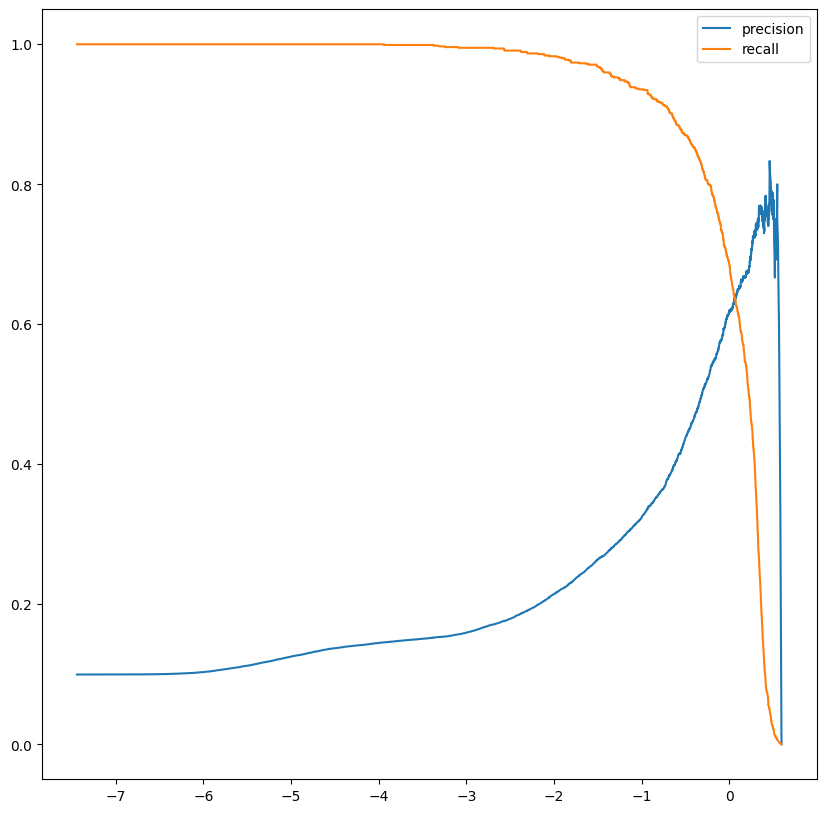

In [14]:
precision, recall, thresholds = precision_recall_curve(y, yhat)
n = len(thresholds)
sns.lineplot(x=thresholds, y=precision[:n], label="precision")
sns.lineplot(x=thresholds, y=recall[:n], label="recall")

Note how pushing the threshold up gives you a higher precision, but a lower recall, and the other way around. This is always a trade-off (do you understand why?)

<font color='green'>

**Answer:** increasing the threshold makes the model more confident in its predictions, leading to higher precision but lower recall because fewer positive instances are retrieved. Whereas, lowering the threshold captures more true positives (higher recall) but also increases false positives, reducing precision.

</font>


Another way to visualize this trade off is with a ROC curve

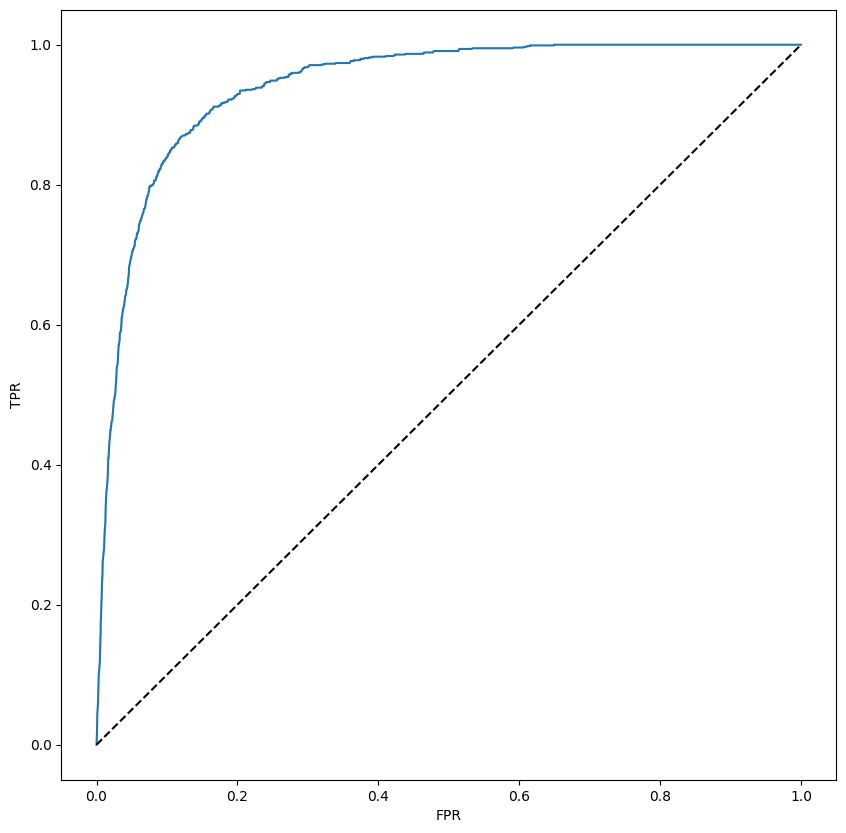

In [15]:
fpr, tpr, thresholds = roc_curve(y, yhat)
plot = sns.lineplot(x=fpr, y=tpr)
plot.set(xlabel="FPR", ylabel="TPR")
plt.plot([0,1], [0,1], "k--")

On the x-axis you see the False Positive Rate. In the beginning, the threshold is very low, so because you dont select any items your FPR is also low. But the same goes for your True Positive Rate.

As you increase the threshold, you start to find True Positives. This is good, but it comes with a price: you will also select False Positives. You can see that, as the TPR starts to rise, the FPR also rises.

Again, you are free to select a threshold to get any TPR you like. But the point of this curve is to maximize the area under the curve. In other words: the dotted diagonal line is what you would expect from blind guessing. Everything above the dotted line is an improvment beyond guessing. Models with a line that comes closer to the upper left corner are better.

Let's switch to the multi-label case. We drop the post-processing function, and train with 10 classes again.

In [16]:
from mltrainer.preprocessors import BasePreprocessor
preprocessor = BasePreprocessor()

fashionfactory = DatasetFactoryProvider.create_factory(DatasetType.FASHION)
streamers = fashionfactory.create_datastreamer(batchsize=32, preprocessor=preprocessor)
trainstreamer = streamers["train"]
validstreamer = streamers["valid"]

2025-02-21 14:31:16.445 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/sarmad/.cache/mads_datasets/fashionmnist
2025-02-21 14:31:16.446 | INFO     | mads_datasets.base:download_data:124 - File already exists at /home/sarmad/.cache/mads_datasets/fashionmnist/fashionmnist.pt


In [17]:
model = imagemodels.CNN(10, (3,3), 32, 64)
settings.epochs=10

trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    traindataloader=trainstreamer.stream(),
    validdataloader=validstreamer.stream(),
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
)
trainer.loop()

2025-02-21 14:31:16.472 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to modellogs/dummy/20250221-143116
2025-02-21 14:31:16.473 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 100/100 [00:00<00:00, 105.33it/s]
2025-02-21 14:31:17.677 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.6392 test 1.0706 metric ['0.5594']
100%|██████████| 100/100 [00:00<00:00, 107.89it/s]
2025-02-21 14:31:18.843 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.8876 test 0.8369 metric ['0.6525']
100%|██████████| 100/100 [00:00<00:00, 103.14it/s]
2025-02-21 14:31:20.081 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.7652 test 0.7615 metric ['0.7137']
100%|██████████| 100/100 [00:00<00:00, 101.51it/s]
2025-02-21 14:31:21.313 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.7329 test 0.8038 metric ['0.6950']
2025-02-21 14:31:21.314 | INFO     | mltrainer.trai

In [18]:
y_true = []
y_pred = []

validdata = validstreamer.stream()
for _ in range(len(validstreamer)):
    X, y = next(validdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.tolist())
    y_true.append(y.tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

[Text(0.5, 80.7222222222222, 'Predicted'),
 Text(95.72222222222221, 0.5, 'Target')]

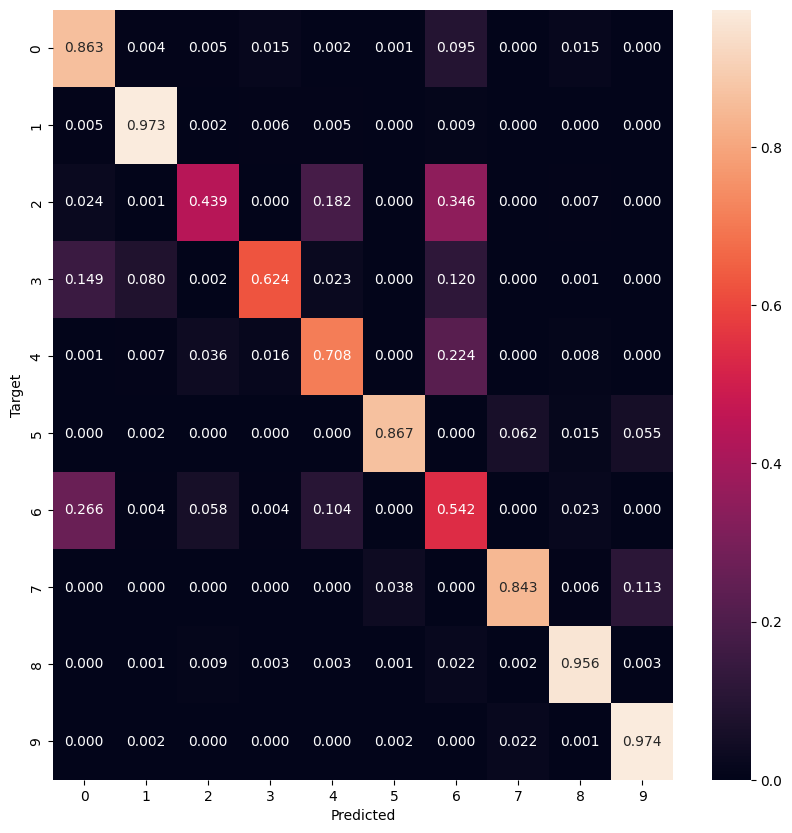

In [19]:
cfm = confusion_matrix(y, yhat)
cfm_norm = cfm / np.sum(cfm, axis=1, keepdims=True)
plot = sns.heatmap(cfm_norm, annot=cfm_norm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

This is a very efficient way to get an overview of the 100 different confusion-cases you could get.

At a glance, you can see which targets are mislabeled the most often, and if they are, what they are confused with for what percentage.

<font color='green'>

**Observation:** for instance, the target value 2 is being most often confused with 4 and 6 with the percentage of 18.2% and 34.6% respectively.

</font>